In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from itertools import combinations
from scipy.stats import pearsonr

In [2]:
save_dir = (
    '/Users/greg/Dropbox (HMS)/Baker_QC_2021/script_output/last_minute_figures'
    '/CD4')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# SARDANA
df = pd.read_parquet(
    '/Volumes/T7 Shield/cylinter_input/sardana-097/output_raw/'
    'checkpoints/clustering.parquet'
    )
channels1 = [
    'anti_CD3', 'Keratin_570', 'aSMA_660', 'PD1_647', 'CD20_488', 'CD68_555',
    'CD8a_660', 'CD163_488', 'FOXP3_570', 'PDL1_647', 'Ecad_488',
    'Vimentin_555', 'CDX2_647', 'LaminABC_488', 'Desmin_555', 'CD31_647',
    'PCNA_488', 'CollagenIV_647', 'CD4_488', 'CD45_PE', 'anti_CD45RO',
    ]
channels2 = ['CD4_488', 'CD45_PE', 'anti_CD45RO']

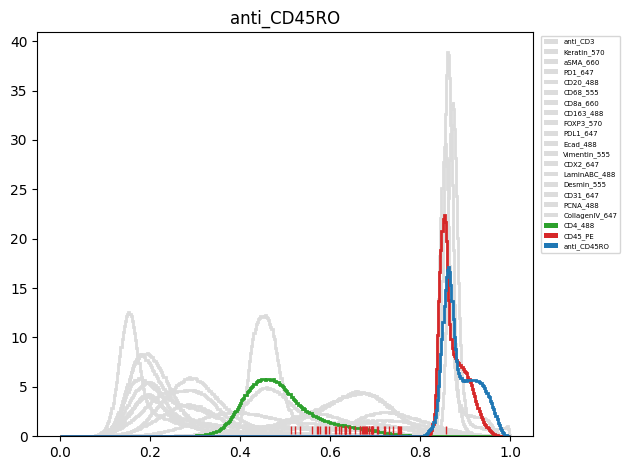

In [3]:
fig, ax = plt.subplots()
handles = []
for channel in channels1:

    if channel == 'CD4_488':
        c = 'tab:green'
    elif channel == 'CD45_PE':
        c = 'tab:red'
    elif channel == 'anti_CD45RO':
        c = 'tab:blue'
    else:
        c = 'gainsboro'

    g = ax.hist(
        df[channel], bins=400, density=True, histtype='step',
        linewidth=2.0, alpha=1.0, color=c
        )
    ax.set_title(channel)

    # add rug plot for specific cluster/channel
    if channel == 'CD4_488':
        y_max = plt.gca().get_ylim()[1]
        test = df[df['cluster_2d'] == 3]
        test = test.sample(n=50)
        for i in test.index:
            plt.plot(
                df[channel][df.index == i], y_max*0.015,
                marker='|', color='tab:red'
                )

    color = g[2][0].get_facecolor()[:-1]
    handles.append(
        Rectangle((0, 0), 1, 1, color=color, alpha=1.0, linewidth=0.0)
        )

plt.legend(handles, channels1, fontsize=5.0, bbox_to_anchor=(1.01, 1.0))
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'sardana.pdf'))
plt.show()
plt.close('all')

CD4_488


/Users/greg/venvs/cylinter_test/lib/python3.11/site-packages/matplotlib/text.py:1419: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))


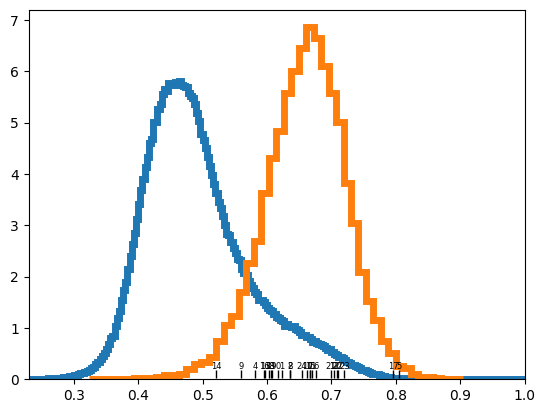

CD45_PE


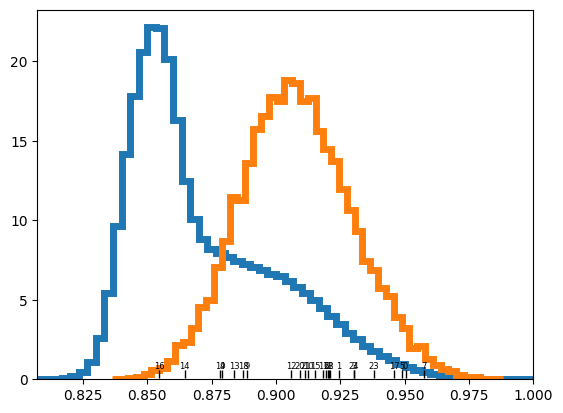

anti_CD45RO


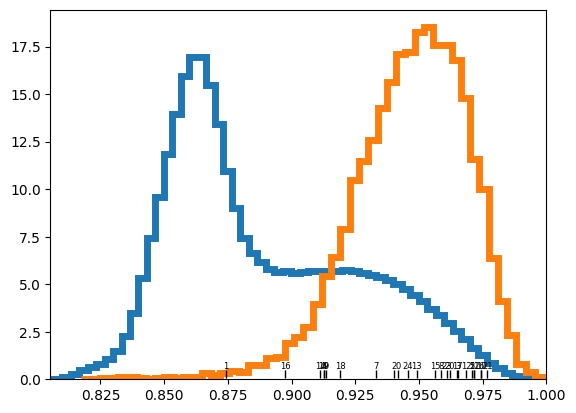

In [4]:
cluster = df[df['cluster_2d'] == 3]
cluster.set_index('CellID', inplace=True)

# CellIDs selected by curateThumbnails modules in CyLinter for SARDANA-097 raw
examples = [
    41060, 1097589, 464713, 503745, 808624, 468824, 413086, 9974, 972474,
    1229834, 209828, 664140, 183871, 515864, 509302, 108317, 437627, 481101,
    878465, 697962, 936016, 82322, 237841, 252763, 485627
    ]
example_dict = dict(zip(examples, [examples.index(i) for i in examples]))

handles = []
for channel in channels2:

    print(channel)

    cutoff = np.percentile(df[channel], q=0.01)

    plt.hist(
        df[channel], bins=300, density=True, histtype='step',
        linewidth=5.0, alpha=1.0
        )

    plt.hist(
        cluster[channel], bins=50, density=True, histtype='step',
        linewidth=5.0, alpha=1.0
        )

    plt.xlim([cutoff, 1.0])

    y_max = plt.gca().get_ylim()[1]

    # add and annotate rug plot
    for i in examples:
        plt.plot(
            cluster[channel][cluster.index == i], y_max*0.015,
            marker='|', color='k',
            )

        label = example_dict[i]
        plt.annotate(
            f'{label}',
            (cluster[channel][cluster.index == i], y_max*0.03),
            textcoords='offset points', xytext=(0, 0), ha='center',
            fontsize=6
            )

    plt.savefig(os.path.join(save_dir, f'{channel}_crop.pdf'))
    plt.show()
    plt.close('all')

/var/folders/_h/pbzrx8ss6n5f031pf4hc97_w0000gp/T/ipykernel_81671/2209023386.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f'{label}', (row[1][0], row[1][1]), textcoords='offset points',


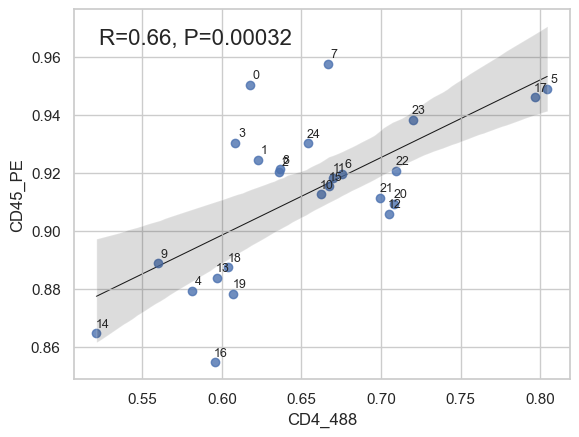

/var/folders/_h/pbzrx8ss6n5f031pf4hc97_w0000gp/T/ipykernel_81671/2209023386.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f'{label}', (row[1][0], row[1][1]), textcoords='offset points',


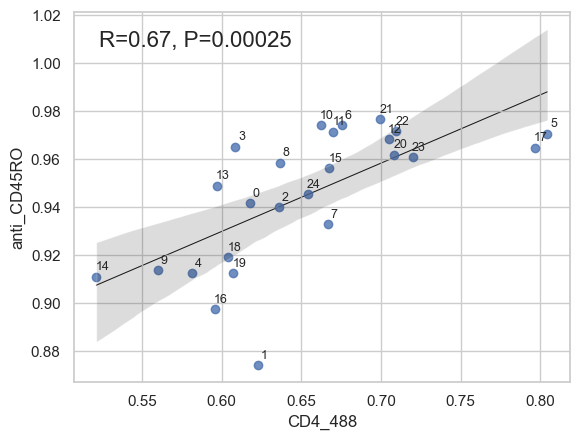

/var/folders/_h/pbzrx8ss6n5f031pf4hc97_w0000gp/T/ipykernel_81671/2209023386.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f'{label}', (row[1][0], row[1][1]), textcoords='offset points',


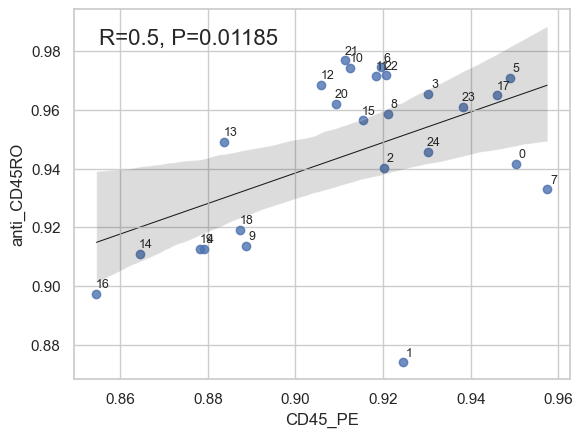

In [9]:
# compute Pearsonr scores and plot
sns.set(font_scale=1)
sns.set_style('whitegrid')
stats = pd.DataFrame(columns=['combo', 'pearsonr', 'pval'])
for e, i in enumerate(combinations(channels2, r=2)):

    ch1 = i[0]
    ch2 = i[1]

    stats.loc[e, 'combo'] = i

    x = cluster[ch1][cluster.index.isin(examples)]
    y = cluster[ch2][cluster.index.isin(examples)]
    res, pval = pearsonr(x=x, y=y, alternative='two-sided')

    stats.loc[e, 'pearsonr'] = res
    stats.loc[e, 'pval'] = pval

    regplot = pd.DataFrame(index=x.index, columns=[ch1, ch2])
    regplot.loc[:, ch1] = x.values
    regplot.loc[:, ch2] = y.values

    regplot[ch1] = regplot[ch1].astype('float')
    regplot[ch2] = regplot[ch2].astype('float')
    
    fig, ax = plt.subplots()
    
    sns.regplot(
        x=ch1,  y=ch2, data=regplot, scatter=True, ax=ax,
        line_kws={'color': 'k', 'alpha': 1.0, 'lw': 0.75, 'zorder': -1}
        )

    # annotate rugplot ticks
    for row in regplot.iterrows():
        idx = row[0]
        val = row[1]
        label = example_dict[idx]
        plt.annotate(
            f'{label}', (row[1][0], row[1][1]), textcoords='offset points',
            xytext=(4.5, 4.5), ha='center', fontsize=9
            )

    # add Pearson R and P-value to plot
    ax.text(
        0.05, 0.95, f'R={round(res, 2)}, P={round(pval, 5)}',
        transform=ax.transAxes, fontsize=16, va='top', ha='left'
        )

    plt.savefig(os.path.join(save_dir, f'{i}.pdf'))
    plt.show()
    plt.close('all')